### Import the necessary program libraries

In [1]:
import pandas as pd
import plotly.graph_objects as go
from classes import KMeansClusterMain, BaseLoader
import plotly.express as px
from funcs import to_float, get_density, get_color
from matplotlib.colors import Normalize
from matplotlib import cm
import matplotlib.colors as mcolors
from sqlalchemy import create_engine
from settings import mariadb_string, mariadb_config

### Select the data

In [3]:
sql_query = """select 
	*
from
	stock_price s
where
	s.symbol = '{}'
group BY
	s.`date`
order by
	s.`date` asc;"""

loader = BaseLoader(mariadb_config)
symbol = loader.choose_id()
df_stock = pd.read_sql(sql_query.format(symbol), create_engine(mariadb_string))
df_stock.info()

Please choose the symbol from the index which data should be analysed.
symbol AMZN: Amazon
symbol BKNG: Booking Holdings
symbol DASH: DoorDash
symbol HD: Home Depot
symbol LOW: Lowe’s
symbol MCD: McDonald's
symbol NKE: Nike
symbol SBUX: Starbucks
symbol TJX: TJX Companies
symbol TSLA: Tesla
You can typ 'q' to quit.


symbol:  AMZN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6466 entries, 0 to 6465
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   symbol  6466 non-null   object 
 1   date    6466 non-null   object 
 2   open    6466 non-null   float64
 3   high    6466 non-null   float64
 4   low     6466 non-null   float64
 5   close   6466 non-null   float64
dtypes: float64(4), object(2)
memory usage: 303.2+ KB


In [4]:
df_stock.head()

,symbol,date,open,high,low,close
0,AMZN,1999-11-01,3.403,3.594,3.316,3.457
1,AMZN,1999-11-02,3.488,3.500,3.253,3.322
2,AMZN,1999-11-03,3.410,3.425,3.250,3.291
3,AMZN,1999-11-04,3.360,3.360,3.050,3.153
4,AMZN,1999-11-05,3.238,3.275,3.113,3.247


### Prepare the data and make some cleaning

In [5]:
df_stock["date"] = pd.to_datetime(df_stock["date"])

# Volatility Calculation
df_stock['volatility_max'] = (df_stock['high'] - df_stock['low']).rolling(21).max()
df_stock['volatility_mean'] = (df_stock['high'] - df_stock['low']).rolling(21).mean()

In [13]:
df_stock.head()

,symbol,date,open,high,low,close,volatility_max,volatility_mean
5114,AMZN,2020-03-02,95.325,97.726,93.500,97.698,4.612,2.554714
5115,AMZN,2020-03-03,98.769,99.817,94.405,95.450,5.412,2.685190
5116,AMZN,2020-03-04,97.329,98.900,96.100,98.792,5.412,2.703667
5117,AMZN,2020-03-05,96.650,98.036,95.500,96.202,5.412,2.718667
5118,AMZN,2020-03-06,93.750,95.544,93.475,95.055,5.412,2.724286


In [14]:
df_stock.tail()

,symbol,date,open,high,low,close,volatility_max,volatility_mean
6461,AMZN,2025-07-11,223.580,226.68,222.370,225.02,6.619,4.245905
6462,AMZN,2025-07-14,225.070,226.66,224.240,225.69,6.619,4.098762
6463,AMZN,2025-07-15,226.200,227.27,225.455,226.35,6.619,4.078048
6464,AMZN,2025-07-16,225.875,226.10,222.180,223.19,6.619,4.053762
6465,AMZN,2025-07-17,223.320,224.50,222.510,223.88,6.619,3.888524


### Check the chart

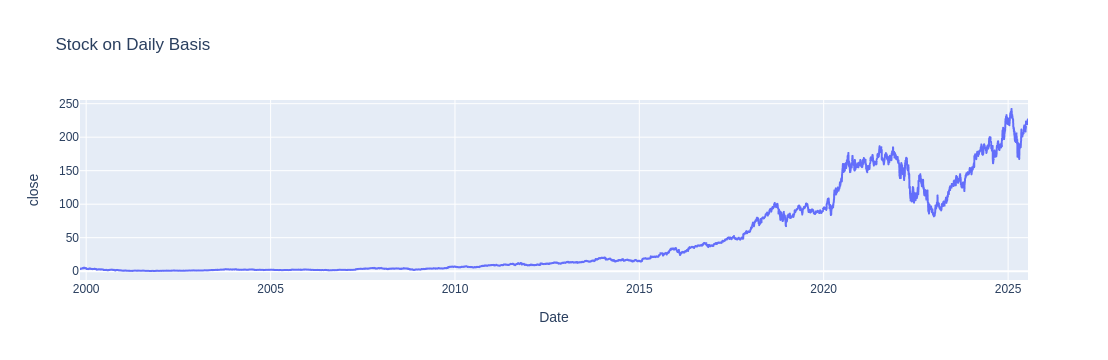

In [8]:
fig = px.line(df_stock, x="date", y="close", title="Stock on Daily Basis", 
              labels={"date": "Date"})

fig.show()

### The Mean Volatility for the cut off the timeframe 

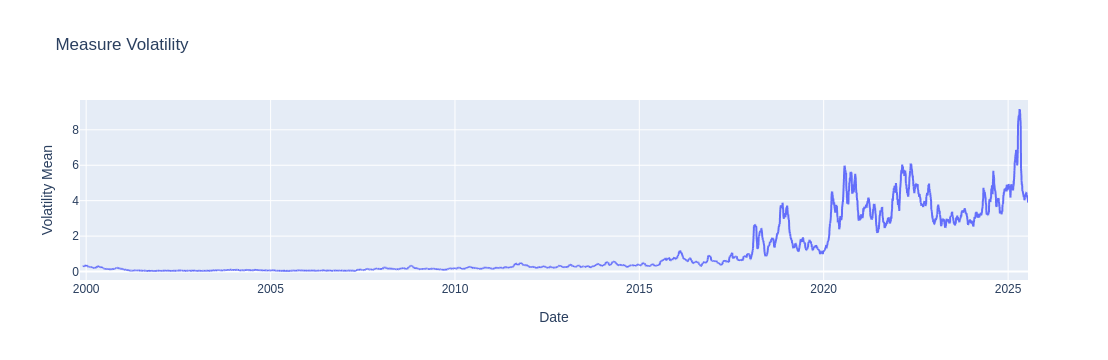

In [9]:
fig = px.line(df_stock, x="date", y="volatility_mean", title="Measure Volatility", 
              labels={"date": "Date", "volatility_mean": "Volatility Mean"})
fig.show()

### The Max Volatility for the entry into the market

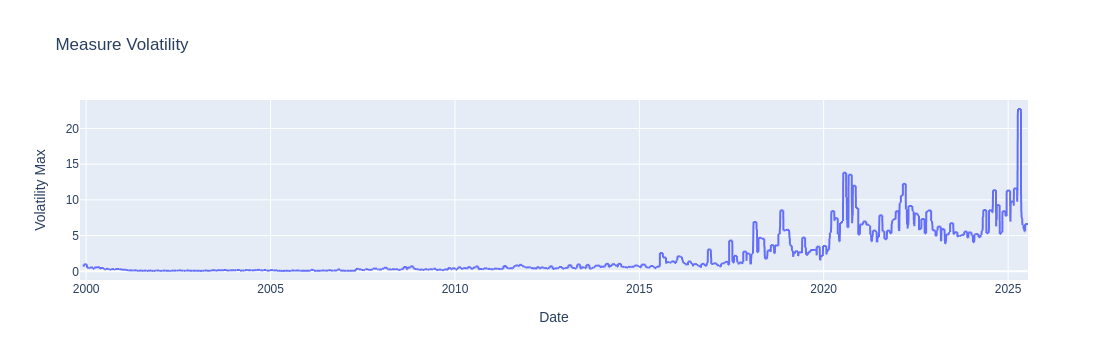

In [10]:
fig = px.line(df_stock, x="date", y="volatility_max", title="Measure Volatility",
              labels={"date": "Date", "volatility_max": "Volatility Max"})
fig.show()

### Truncate the timeframe

In [11]:
# Select the timestamp
time_stamp = '2020-03-01'
symbol = df_stock.loc[0, "symbol"]
delete_string = f"DELETE FROM stock_price WHERE symbol='{symbol}' AND `date`<'{time_stamp}';"

# Truncate the data
df_stock = df_stock[df_stock['date'] >= time_stamp]
affected_rows = loader.query(delete_string)
print(df_stock.head())
print(df_stock.tail())
print("Affected Rows:", affected_rows)

# Hier stehen geblieben

AttributeError: 'BaseLoader' object has no attribute 'data_connection'

### Compute the main process

1. Calculate the percentage change on daily bases

2. Within the percentage change datapoints calculate the clusters with the help of the KMeans-Clustering-Algorithm

3. Calculate the necessary density column with the cluster labels and sum up the kmeans centroids with that and save them

In [15]:
# Compute the percentage change
df_stock["perc_change"] = df_stock["close"].pct_change()
df_stock.dropna(inplace=True)
df_stock = df_stock[df_stock['perc_change'] != 0.0]

# Here comes KMeans
datapoints = df_stock["perc_change"].to_list()
kmeans = KMeansClusterMain(3)
kmeans.fit(datapoints) 

# Assign the clusters
df_stock["cluster"] = kmeans.labels
df_stock["cluster"] = pd.to_numeric(df_stock["cluster"])

# Get the density for the colormap
df_stock["density"] = df_stock["cluster"].rolling(21).apply(get_density, kwargs={'orig_density': kmeans.centroids})

# cluster_str needed for kmeans volatility cluster graph.
df_stock["cluster_str"] = df_stock.cluster.astype(str)
df_stock['perc_change'] = df_stock['perc_change'] * 100

print(df_stock.isna().any())
print(df_stock.info())

symbol             False
date               False
open               False
high               False
low                False
close              False
volatility_max     False
volatility_mean    False
perc_change        False
cluster            False
density             True
cluster_str        False
dtype: bool
<class 'pandas.core.frame.DataFrame'>
Index: 1348 entries, 5115 to 6465
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   symbol           1348 non-null   object        
 1   date             1348 non-null   datetime64[ns]
 2   open             1348 non-null   float64       
 3   high             1348 non-null   float64       
 4   low              1348 non-null   float64       
 5   close            1348 non-null   float64       
 6   volatility_max   1348 non-null   float64       
 7   volatility_mean  1348 non-null   float64       
 8   perc_change      1348 non-null   float64       


### Need it for further processing of the boundaries and the coloring

In [16]:
describe_ser = df_stock["density"].describe()
upper_limit = describe_ser["mean"] + (describe_ser["std"] * 2)
lower_limit = describe_ser["mean"] - (describe_ser["std"] * 2)
print(describe_ser)

count    1328.000000
mean        0.018682
std         0.079466
min        -0.194054
25%        -0.047114
50%         0.037331
75%         0.069906
max         0.219502
Name: density, dtype: float64


### Checking the volatility in percentage daily changes

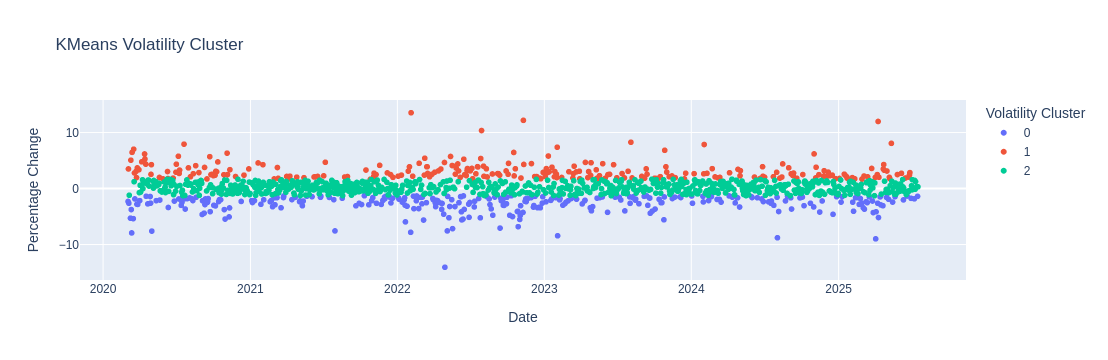

In [17]:
fig = px.scatter(df_stock, x="date", y="perc_change", color="cluster_str", 
                 title="KMeans Volatility Cluster", 
                 labels={"date": "Date", "perc_change": "Percentage Change", 
                         "cluster_str": "Volatility Cluster",})
fig.show()

In [18]:
# Need it for the sell order
df_stock.loc[df_stock['cluster'] == 1]['perc_change'].describe()


count    263.000000
mean       3.171159
std        1.705410
min        1.677519
25%        2.104386
50%        2.630820
75%        3.629697
max       13.535860
Name: perc_change, dtype: float64

### Show the boundaries

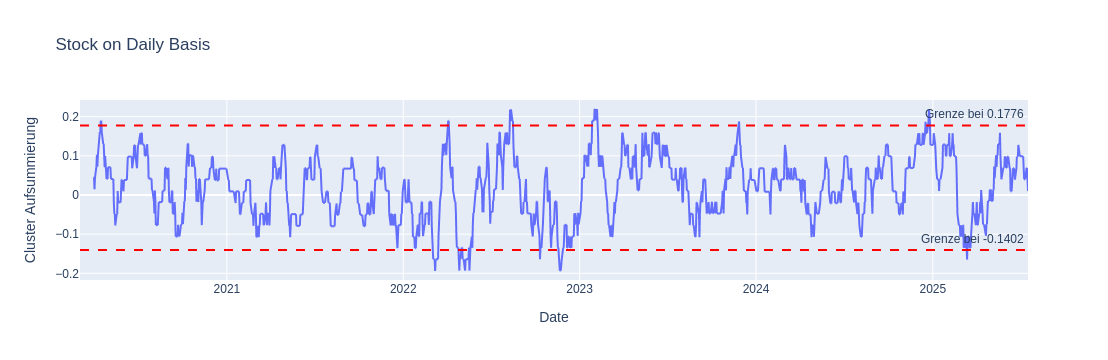

In [19]:
fig = px.line(df_stock, x="date", y="density", title="Stock on Daily Basis",
                  labels={"date": "Date", "density": "Cluster Aufsummierung"})

fig.add_hline(y=upper_limit, line_dash="dash", line_color="red", annotation_text=f"Grenze bei {round(upper_limit,4)}")
fig.add_hline(y=lower_limit, line_dash="dash", line_color="red", annotation_text=f"Grenze bei {round(lower_limit,4)}")


fig.show()

### Color the price history according to the column density

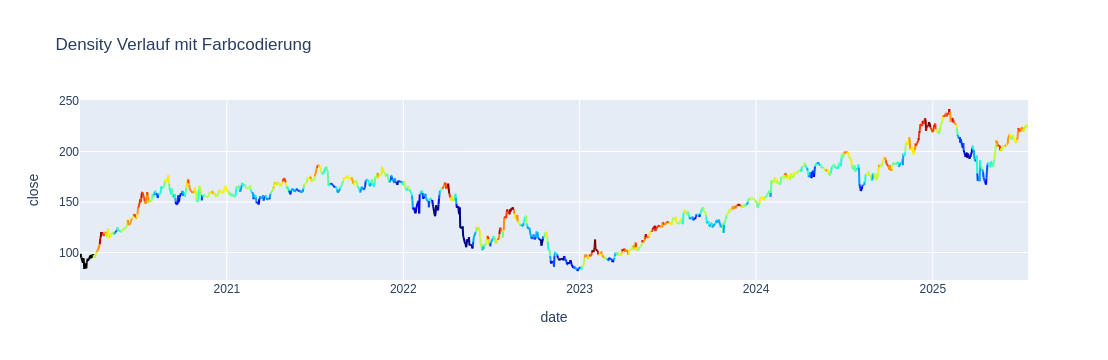

Untere Grenze (vmin): -0.14
Obere Grenze (vmax): 0.18
Mittelwert: 0.02


In [20]:
# Statistical limits for clipping
vmin = lower_limit
vmax = upper_limit

# Create normalization
norm = Normalize(vmin=vmin, vmax=vmax, clip=True)

# Create plotly-figure
fig = go.Figure()

# Draw line segments with colors based on density
for i in range(len(df_stock) - 1):
    density_value = df_stock["density"].iloc[i]
    color = get_color(density_value, norm)
    
    fig.add_trace(go.Scatter(
        x=df_stock["date"].iloc[i:i+2],  # Zwei Punkte verbinden
        y=df_stock["close"].iloc[i:i+2],
        mode="lines",
        line=dict(color=color, width=2),
        showlegend=False,
    ))

# Adjust layout
fig.update_layout(
    title="Density Verlauf mit Farbcodierung",
    xaxis_title="date",
    yaxis_title="close",
    # Add colorbar
    coloraxis=dict(
        colorbar=dict(
            title="Density",
            ticktext=["Niedrig (Blau)", "Neutral (Grün)", "Hoch (Rot)"],
            tickvals=[vmin, (vmin+vmax)/2, vmax]
        ),
        colorscale="jet",
        cmin=vmin,
        cmax=vmax
    )
)

fig.show()

# Optional: Ausgabe der Grenzwerte zur Kontrolle
print(f"Untere Grenze (vmin): {vmin:.2f}")
print(f"Obere Grenze (vmax): {vmax:.2f}")
print(f"Mittelwert: {describe_ser['mean']:.2f}")